In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'
if not os.path.exists(volume_dir):
    os.makedirs(volume_dir)

In [ ]:
######## reconstruct outer contour #######

In [4]:
downsample_factor = 8

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [5]:
from skimage.measure import find_contours

def construct_contour_volume(stack):
    
    # build annotation volume
    section_bs_begin, section_bs_end = section_range_lookup[stack]
    print section_bs_begin, section_bs_end
    
    dm = DataManager(stack=stack)

    volume = np.zeros((dm.image_height/downsample_factor, 
                       dm.image_width/downsample_factor, 
                       int(section_number_lookup[stack]*z_xy_ratio_downsampled)), np.bool)

    for sec in range(section_bs_begin, section_bs_end+1):

#         print sec

        m = cv2.imread(os.environ['DATA_DIR'] + \
        '/%(stack)s_thumbnail_aligned_mask_cropped/%(stack)s_%(sec)04d_thumbnail_aligned_mask_cropped.png' % \
                         {'stack': stack, 'sec': sec}, )[..., 0]

        m[0,:] = 0
        m[-1,:] = 0
        m[:,0] = 0
        m[:,-1] = 0

        m_padded = np.pad(m, ((5,5),(5,5)), mode='constant', constant_values=0)

        cnts = find_contours(m_padded, .5)
        cnts = [cnt.astype(np.int) - (5,5) for cnt in cnts if len(cnt) > 300]
        yxs = np.array([(y,x) for y,x in cnts[0] if y > 1 and x > 1]).astype(np.int)

        b = np.ascontiguousarray(yxs).view(np.dtype((np.void, yxs.dtype.itemsize * yxs.shape[1])))
        _, idx = np.unique(b, return_index=True)

        yxs = yxs[idx] # in thumbnail frame

        volume[yxs[:,0]*32/downsample_factor, 
               yxs[:,1]*32/downsample_factor, 
               int(z_xy_ratio_downsampled*sec):int(z_xy_ratio_downsampled*(sec+1))] = 1

    return volume

In [6]:
atlas_contour_volume = construct_contour_volume('MD589')
test_contour_volume = construct_contour_volume('MD594')

93 368
93 364


# Matching experiment

In [ ]:
for sec in range(section_bs_begin, section_bs_end+1):
#     plt.figure(figsize=(20,20));
    plt.imshow(test_contour_volume[..., int(sec*z_xy_ratio_downsampled)], cmap=plt.cm.gray);
    plt.title('section %d, z = (%d, %d)'%(sec, int(sec*z_xy_ratio_downsampled), 
                                         int(z_xy_ratio_downsampled*(sec+1))-1));
    plt.show();

In [ ]:
# virtual section in coronal

for x in range(0, volume.shape[1], 100):
#     plt.figure(figsize=(20,20));
    plt.imshow(volume[:, x, :], cmap=plt.cm.gray);
    plt.title('x = %d' % x);
    plt.show();

In [89]:
nzs_yxz = np.where(atlas_contour_volume)
nzs_yxz = np.asarray(nzs_yxz).T
nzs_xyz = nzs_yxz[:, [1,0,2]]

In [ ]:
test_nzs_yxz = np.where(test_contour_volume)
test_nzs_yxz = np.asarray(test_nzs_yxz).T
test_nzs_xyz = test_nzs_yxz[:, [1,0,2]]

In [93]:
test_nzs_xyz_subsampled = test_nzs_xyz[::100]
n = test_nzs_xyz_subsampled.shape[0]
print n

18001


In [94]:
pp = np.random.permutation(n)

In [96]:
test_nzs_xyz_subsampled = test_nzs_xyz_subsampled[pp]

In [97]:
from scipy.spatial import KDTree

In [98]:
import sys
sys.setrecursionlimit(10000)

tree = KDTree(nzs_xyz)

In [99]:
import time
from joblib import Parallel, delayed

In [105]:
def tree_query(f,l):
    return [tree.query(xyz) for xyz in test_nzs_global[f:l+1]]

In [101]:
from itertools import chain

In [102]:
def first_last_tuples_distribute_over(first_sec, last_sec, n_host):
    secs_per_job = (last_sec - first_sec + 1)/float(n_host)
    if secs_per_job < 1:
    	first_last_tuples = [(i,i) for i in range(first_sec, last_sec+1)]
    else:
    	first_last_tuples = [(int(first_sec+i*secs_per_job), int(first_sec+(i+1)*secs_per_job-1) if i != n_host - 1 else last_sec) for i in range(n_host)]
    return first_last_tuples

In [109]:
test_nzs_global = None

In [110]:
def compute_nn_distance_parallel(test_nzs):
    
    global test_nzs_global
    test_nzs_global = test_nzs
    
    num_per_iter = 10000

    test_nns_all = []

    t1 = time.time()

    for i in range(0, n, num_per_iter):

        t = time.time()

        test_nns = Parallel(n_jobs=16)(delayed(tree_query)(f, l) 
                           for f, l in first_last_tuples_distribute_over(i, min(n-1, i+num_per_iter-1), 16))

        test_nns_list = list(chain(*test_nns))

        test_nns_all.append(test_nns_list)

        print time.time() - t

    print time.time() - t1
    
    test_nns_all = list(chain(*test_nns_all))
    all_dists = np.array(test_nns_all)[:,0]
    
    return all_dists

In [111]:
all_dists = compute_nn_distance_parallel(test_nzs_xyz_subsampled)

19.6921889782
17.6842420101
37.3766350746


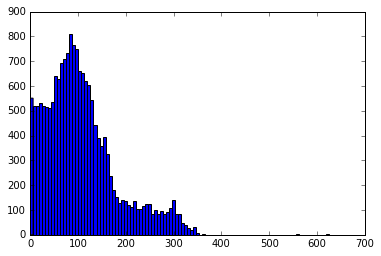

In [112]:
plt.hist(all_dists, bins=100);

In [116]:
test_nzs_xyz_subsampled.shape

(18001, 3)

In [114]:
all_dists = compute_nn_distance_parallel(test_nzs_xyz_prime_subsampled)

8.67562294006
8.56838607788
17.244204998


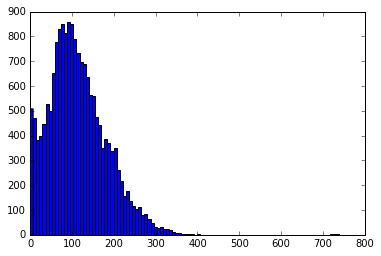

In [117]:
plt.hist(all_dists, bins=100);